In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
!cp -r /content/drive/MyDrive/Colab/data /content/data

%cd /content/data
%ls

Mounted at /content/drive
/content/data
AnoMNIST/  latent_space_mappings/  latent_space_mappings_cp/  MNIST/


In [2]:
import torch
import torch.nn as nn
from PIL import Image
from torchvision import transforms, datasets

In [3]:
class Generator(nn.Module):
    def __init__(self, size_z, num_feature_maps, num_color_channels):
        super(Generator, self).__init__()
        self.size_z = size_z
        self.network = nn.Sequential(
            nn.ConvTranspose2d(self.size_z, num_feature_maps * 4, 4, 1, 0, bias=False),
            nn.BatchNorm2d(num_feature_maps * 4),
            nn.ReLU(True),

            nn.ConvTranspose2d(num_feature_maps * 4, num_feature_maps * 2, 3, 2, 1, bias=False),
            nn.BatchNorm2d(num_feature_maps * 2),
            nn.ReLU(True),

            nn.ConvTranspose2d(num_feature_maps * 2, num_feature_maps, 4, 2, 1, bias=False),
            nn.BatchNorm2d(num_feature_maps),
            nn.ReLU(True),

            nn.ConvTranspose2d(num_feature_maps, num_color_channels, 4, 2, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, x):
        output = self.network(x)
        return output

    def gen_shifted(self, x, shift):
        shift = torch.unsqueeze(shift, -1)
        shift = torch.unsqueeze(shift, -1)
        return self.forward(x + shift)

In [4]:
class Discriminator(nn.Module):
    def __init__(self, num_feature_maps, num_color_channels):
        super(Discriminator, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(num_color_channels, num_feature_maps, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
        )
        self.layer2 = nn.Sequential(
            nn.Conv2d(num_feature_maps, num_feature_maps * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(num_feature_maps * 2),
            nn.LeakyReLU(0.2, inplace=True),
        )
        self.layer3 = nn.Sequential(
            nn.Conv2d(num_feature_maps * 2, num_feature_maps * 4, 3, 2, 1, bias=False),
            nn.BatchNorm2d(num_feature_maps * 4),
            nn.LeakyReLU(0.2, inplace=True),
        )
        self.fc = nn.Sequential(
            nn.Conv2d(num_feature_maps * 4, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        feature = out
        out = self.fc(out)
        return out.view(-1, 1).squeeze(1), feature

In [44]:
class LatentSpaceMapper:

    def __init__(self, generator: Generator, discriminator: Discriminator, device):
        self.generator: Generator = generator
        self.generator.to(device)
        self.discriminator: Discriminator = discriminator
        self.discriminator.to(device)
        self.device = device

    def map_image_to_point_in_latent_space(self, image: torch.Tensor, size_z=100, opt_iterations=10000):
        z = torch.randn(1, size_z, 1, 1, device=self.device, requires_grad=True)
        z_optimizer = torch.optim.Adam([z], lr=1e-4)
        losses = []

        for i in range(opt_iterations):
            loss = self.__get_anomaly_score(z, image.unsqueeze(0).to(self.device))
            loss.backward()
            z_optimizer.step()
            if i % 50000 == 0 or i == opt_iterations-1:
                print(f"Iteration: {i} -- Loss: {loss.data.item()}")
                losses.append(loss.data.item())

        return z

    def __get_anomaly_score(self, z, x_query):
        lamda = 0.1
        g_z = self.generator(z.to(self.device))
        _, x_prop = self.discriminator(x_query)
        _, g_z_prop = self.discriminator(g_z)

        loss_r = torch.sum(torch.abs(x_query - g_z))
        loss_d = torch.sum(torch.abs(x_prop - g_z_prop))

        return (1 - lamda) * loss_r + lamda * loss_d

In [6]:
import os
import pandas as pd
from PIL import Image
from torch.utils.data import Dataset


class AnoMNIST(Dataset):
    def __init__(self, root_dir, transform=None):
        root_dir = os.path.join(root_dir, "AnoMNIST")
        assert os.path.exists(os.path.join(root_dir, "anomnist_dataset.csv")), "Invalid root directory"
        self.root_dir = root_dir
        self.transform = transform
        self.label = pd.read_csv(os.path.join(root_dir, "anomnist_dataset.csv"))

    def __len__(self):
        return len(self.label)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir, self.label.iloc[idx, 0])
        image_label = {"label": self.label.iloc[idx, 1], "anomaly": self.label.iloc[idx, 2]}
        anomaly = self.label.iloc[idx, 2]
        image = Image.open(img_name)

        if self.transform:
            image = self.transform(image)

        return image, image_label


In [7]:
class CustomMNIST(datasets.MNIST):
  def __getitem__(self, idx):
    return super(CustomMNIST, self).__getitem__(idx)[0], {"label": super(CustomMNIST, self).__getitem__(idx)[1], "anomaly": False}

In [ ]:
mnist_dataset = CustomMNIST(
  root="./",
  train=True,
  download=True,
)

# mnist_dataset[0]

ano_mnist_dataset = AnoMNIST(
  root_dir="./",
)

print(mnist_dataset[0])
print(ano_mnist_dataset[0])

In [9]:
def get_ano_mnist_dataset(transform, root_dir, labels=[], train_size=0.9):
    ano_mnist_dataset = AnoMNIST(
        root_dir=root_dir,
        transform=transform
    )

    mnist_dataset = CustomMNIST(
        root=root_dir,
        train=True,
        transform=transform,
        download=True,
    )

    dat = torch.utils.data.ConcatDataset([ano_mnist_dataset, mnist_dataset])

    if len(labels) > 0:
        dat = [d for d in dat if (d[1]['label'] in labels)]

    absolute_train_size = int(len(dat) * train_size)
    absolute_test_size = len(dat) - absolute_train_size
    return torch.utils.data.random_split(dat, [absolute_train_size, absolute_test_size])

In [10]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
num_color_channels = 1
num_feature_maps_g = 64
num_feature_maps_d = 64
size_z = 100

device

device(type='cuda')

In [11]:
generator = Generator(size_z=size_z,
                      num_feature_maps=num_feature_maps_g,
                      num_color_channels=num_color_channels).to(device)
discriminator = Discriminator(num_feature_maps=num_feature_maps_d,
                              num_color_channels=num_color_channels).to(device)

generator.load_state_dict(torch.load("/content/drive/MyDrive/Colab/saved_models/generator.pkl", map_location=torch.device(device)))
discriminator.load_state_dict(torch.load('/content/drive/MyDrive/Colab/saved_models/discriminator.pkl', map_location=torch.device(device)))

<All keys matched successfully>

In [12]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=(.5,), std=(.5,))
])
ano_mnist_dataset, ano_mnist_dataset_test = get_ano_mnist_dataset(transform=transform, root_dir="./", labels=[9])

/content/data
Iteration: 0 -- Loss: 406.6203308105469
Iteration: 1999 -- Loss: 245.9066162109375


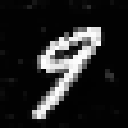

Iteration: 0 -- Loss: 425.0857849121094
Iteration: 1999 -- Loss: 375.71392822265625


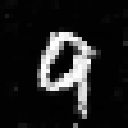

Iteration: 0 -- Loss: 421.1220703125
Iteration: 1999 -- Loss: 376.33905029296875


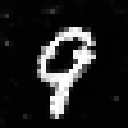

Iteration: 0 -- Loss: 534.81494140625
Iteration: 1999 -- Loss: 502.9909973144531


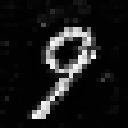

Iteration: 0 -- Loss: 377.8815612792969
Iteration: 1999 -- Loss: 346.5819396972656


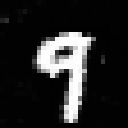

Iteration: 0 -- Loss: 454.9298095703125
Iteration: 1999 -- Loss: 383.32489013671875


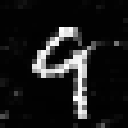

Iteration: 0 -- Loss: 402.8111267089844
Iteration: 1999 -- Loss: 334.3075256347656


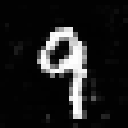

Iteration: 0 -- Loss: 397.13079833984375
Iteration: 1999 -- Loss: 309.8979797363281


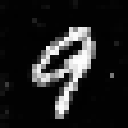

Iteration: 0 -- Loss: 459.6687927246094


KeyboardInterrupt: ignored

In [54]:
import csv
import shutil
import PIL
from IPython.display import clear_output

def create_cp(iteration_number):
  print("CREATING CHECKPOINT...")
  drive.mount('/content/drive', force_remount=True)
  shutil.make_archive(f"/content/drive/MyDrive/Colab/data/latent_space_mappings_cp/latent_space_mappings_cp{iteration_number}", 'zip', "/content/data/latent_space_mappings")

def save_to_drive(mapped_z, iteration_number, csv_path):
  torch.save(mapped_z, f'/content/drive/MyDrive/Colab/data/latent_space_mappings/mapped_z_{iteration_number}.pt')
  shutil.copy(csv_path, "/content/drive/MyDrive/Colab/data/latent_space_mappings/latent_space_mappings.csv")

%cd /content/data
base_folder = "/content/data/latent_space_mappings"
csv_path = os.path.join(base_folder, "latent_space_mappings.csv")

if not os.path.exists(base_folder):
    os.mkdir(base_folder)

if os.path.exists(base_folder):
    shutil.rmtree(base_folder)
    os.mkdir(base_folder)

with open(csv_path, 'a', newline='') as file:
    writer = csv.writer(file)
    fields = ["filename", "label", "anomaly"]
    writer.writerow(fields)

# Start mapping
only_map_anomalies = True
t = transforms.ToPILImage()
lsm: LatentSpaceMapper = LatentSpaceMapper(generator=generator, discriminator=discriminator, device=device)
mapped_images = []
cp_counter = 0
counter = len(ano_mnist_dataset)
for img in ano_mnist_dataset:

    # print(f"{counter} images left")

    if (img[1]["anomaly"] == True and only_map_anomalies) or not only_map_anomalies:
        mapped_z = lsm.map_image_to_point_in_latent_space(img[0], opt_iterations=2000)
        mapped_images.append(mapped_z)
        with open(csv_path, 'a', newline='') as file:
            writer = csv.writer(file)
            fields = [f'mapped_z_{counter}.pt', img[1]["label"], img[1]["anomaly"]]
            writer.writerow(fields)

        torch.save(mapped_z, f'./latent_space_mappings/mapped_z_{counter}.pt')
        save_to_drive(mapped_z, counter, csv_path)
        cp_counter += 1
        if cp_counter % 50 == 0:
          create_cp(counter)
          clear_output

        original_img = generator(mapped_z).cpu()
        img = t(original_img[0]).resize((128, 128), PIL.Image.NEAREST)
        img.show()

    counter-=1

create_cp(0)

In [23]:
drive.mount('/content/drive', force_remount=True)

%cd /content/data
base_folder = "/content/drive/MyDrive/Colab/data/latent_space_mappings"

if os.path.exists(base_folder):
    shutil.rmtree(base_folder)
    os.mkdir(base_folder)

!cp -r /content/data/latent_space_mappings /content/drive/MyDrive/Colab/data

Mounted at /content/drive
/content/data


In [ ]:
# img = generator(mapped_z)
# img = tpi(torch.squeeze(img))
# img.show()